In [1]:
import numpy as np
from EM import EM
from plot import plot
import matplotlib.pyplot as plt
import pickle

In [2]:
signal_context = {}

In [3]:
signal_name = 'creatinine'

treatment_names = {}
treatment_names['dialysis'] = ['dialysis'] 
treatment_names['nephrotoxic_drugs'] = ['acetaminophen_dose','celecoxib_dose','diclofenac_dose','ibuprofen_dose','indomethacin_dose',
'ketorolac_dose','meloxicam_dose','naproxen_dose']
treatment_names['dronedarone'] = ['dronedarone_dose']
treatment_names['diuretic'] = ['eplerenone_dose', 'amiloride_dose', 'hydrochlorothiazide_dose',
'spironolactone_dose', 'triamterene_dose', 'chlorothiazide_dose', 'indapamide_dose', 'torsemide_dose', 
'acetazolamide_dose', 'mannitol_dose']
treatment_names['ace_i'] = ['lisinopril_dose',
 'ramipril_dose',
 'benazepril_dose',
 'enalaprilat_dose',
 'captopril_dose',
 'perindopril_dose',
 'trandolapril_dose']
treatment_names['arb'] = ['valsartan_dose',
 'telmisartan_dose',
 'irbesartan_dose',
 'losartan_dose',
 'candesartan_dose']

#treatment_names['search'] = ['losartan']

chronic_keywords = ['chronic_kidney', 'kidney_cancer', 'renal', 'esrd', 'sickle_cell']

demographic_names = ['gender', 'admit_weight']
signal_context[signal_name] = (treatment_names, chronic_keywords, demographic_names)

In [4]:
signal_name = 'inr'

treatment_names = {}
treatment_names['nsaid'] = ['acetaminophen_dose','celecoxib_dose','diclofenac_dose','ibuprofen_dose','indomethacin_dose',
'ketorolac_dose','meloxicam_dose','naproxen_dose', 'aspirin_dose']
treatment_names['anticoagulant'] = ['warfarin_dose','heparin_dose','dabigatran_dose','edoxaban_dose','rivaroxaban_dose',
'apixaban_dose','enoxaparin_dose','dalteparin_dose','fondaparinux_dose']
treatment_names['transfusion_platelets'] = ['transfuse_platelets']

chronic_keywords = ['liver_disease', 'sickle_cell']

demographic_names = []

signal_context[signal_name] = (treatment_names, chronic_keywords, demographic_names)

In [5]:
signal_name = 'platelets'
treatment_names = {}
treatment_names['platelets_transfusion'] = ['transfuse_platelets']
treatment_names['ditp'] = ['ibuprofen_dose',
 'acetaminophen_dose',
 'ampicillin_dose',
 'heparin_dose',
 'vancomycin_dose',
 'piperacillin_tazobac_dose',
 'naproxen_dose']

chronic_keywords = ['liver', 'sickle_cell']
demographic_names = []
signal_context[signal_name] = (treatment_names, chronic_keywords, demographic_names)

In [6]:
signal_name = 'lactate'
treatment_names = {}
treatment_names['ivf'] = ['crystalloid_fluid', 'crystalloid_fluid_order']
treatment_names['antibiotics'] = ['vancomycin_dose',
'piperacillin_tazobac_dose',
'ceftriaxone_dose',
'meropenem_dose',
'cefotaxime_dose', 'gentamicin_dose', 'ceftazidime_dose', 'amikacin_dose',
'amphotericin_b_ambisome_dose', 'amphotericin_b_fungizone_dose']
treatment_names['drugs_elevate_lactate'] = ['acetaminophen_dose',
 'epinephrine_dose',
 'propofol_dose',
 'theophylline_dose',
 'betaxolol_dose',
 'metformin_dose','albuterol_dose', 'salmeterol_dose']

#treatment_names['search'] = ['cocaine']

chronic_keywords = ['chronic_kidney', 'kidney_cancer', 'renal', 'esrd', 'diabete', 'liver']
demographic_names = []
signal_context[signal_name] = (treatment_names, chronic_keywords, demographic_names)

In [7]:
signal_name = 'bun'
treatment_names = {}
treatment_names['dialysis'] = ['dialysis'] 
treatment_names['diuretic'] = ['eplerenone_dose', 'amiloride_dose', 'hydrochlorothiazide_dose',
'spironolactone_dose', 'triamterene_dose', 'chlorothiazide_dose', 'indapamide_dose', 'torsemide_dose', 
'acetazolamide_dose', 'mannitol_dose']
treatment_names['drugs_increase'] = ['vancomycin_dose',
 'furosemide_dose',
 'carbamazepine_dose',
 'rifampin_dose',
 'hydrochlorothiazide_dose',
 'spironolactone_dose',
 'methotrexate_dose',
 'chlorothiazide_dose',
 'methyclothiazide_dose',
 'amphotericin_b_ambisome_dose',
 'amphotericin_b_fungizone_dose',
 'cefazolin_dose',
 'ceftriaxone_dose',
 'ceftazidime_dose',
 'cefuroxime_dose',
 'cefotaxime_dose']

chronic_keywords = ['chronic_kidney', 'kidney_cancer', 'renal', 'esrd', 'heart_failure', 'liver']

demographic_names = []
signal_context[signal_name] = (treatment_names, chronic_keywords, demographic_names)

In [8]:
# EM Setting
training_pct = .8
single_effect = False

In [12]:
%%time
all_signals = ['creatinine', 'bun', 'lactate', 'platelets', 'inr']
past_effects = [2, 2, 2, 2, 3]
all_params = {}

for s, signal_name in enumerate(all_signals):
    num_past_effects = past_effects[s]
    treatment_names, chronic_keywords, demographic_names = signal_context[signal_name]
    data = np.load('../Data/'+signal_name+'_preprocessed_data.npz')
    
    num_iter = 3 # number of iterations to average over coefficients
    # store coefficients averaged over multiple runs of EM
    A = np.zeros((num_iter, num_past_effects, len(treatment_names.keys())))
    b = np.zeros((num_iter, len(chronic_keywords) + len(demographic_names)))
    transition_std = np.zeros(num_iter)
    observation_std = np.zeros(num_iter)
    initial_state_std = np.zeros(num_iter)
    initial_state_mean = np.zeros(num_iter)
    mse = []
    loglik = []

    for i in range(num_iter):
        em = EM(data['y_mtx'], data['X_mtx'], data['c_mtx'], num_past_effects, K=0, train_pct=training_pct, X_prev_given=True,
            X_prev = data['X_prev_mtx'], single_effect=single_effect)
        em.run_EM(2000)
        A[i, :, :] = em.A
        b[i, :] = em.b
        initial_state_mean[i] =  em.init_z
        initial_state_std[i] = np.sqrt(em.sigma_0)
        transition_std[i] = np.sqrt(em.sigma_1)
        observation_std[i] = np.sqrt(em.sigma_2)
        mse.append(em.mse)
        loglik.append(em.obs_log_lik)
        print('Finish run {} for {}'.format(i+1, signal_name))
        
    all_params[signal_name] = [A, b, initial_state_mean, initial_state_std, transition_std, observation_std, mse, loglik]

#pickle.dump(all_params, open('../Data/est_params.pkl', 'wb'))

iteration 1
iteration 2


KeyboardInterrupt: 

In [13]:
all_params = pickle.load(open('../Data/est_params.pkl', 'rb'))
for signal_name in all_signals:
    learned_params = all_params[signal_name]
    A = learned_params[0]
    b = learned_params[1]
    initial_state_mean = learned_params[2]
    initial_state_std = learned_params[3]
    transition_std = learned_params[4]
    observation_std = learned_params[5]
    treatment_names, chronic_keywords, demographic_names = signal_context[signal_name]
    print('{} coefficients averaged over {} runs'.format(signal_name, num_iter))
    for i, treatment in enumerate(treatment_names.keys()):
        print('Coefficient for {}: {}'.format(treatment, np.round(np.average(A, axis=0)[:, i], 4)))
    static_types = chronic_keywords + demographic_names
    for j, static in enumerate(static_types):
        print('Coefficient for {}: {}'.format(static, np.round(np.average(b, axis=0)[j], 4)))
    print('initial state mean: {}'.format(np.round(np.average(initial_state_mean), 4)))
    print('initial state std: {}'.format(np.round(np.average(initial_state_std), 4)))
    print('transition noise (std): {}'.format(np.round(np.average(transition_std), 4)))
    print('observation noise (std): {}'.format(np.round(np.average(observation_std), 4)))
    print('')

creatinine coefficients averaged over 3 runs
Coefficient for dialysis: [-1.3292 -0.8098]
Coefficient for nephrotoxic_drugs: [-0.0197 -0.0273]
Coefficient for dronedarone: [-0.059   0.1168]
Coefficient for diuretic: [0.0395 0.0134]
Coefficient for ace_i: [ 0.0023 -0.0109]
Coefficient for arb: [0.0846 0.048 ]
Coefficient for chronic_kidney: 1.291
Coefficient for kidney_cancer: 0.6775
Coefficient for renal: 0.4088
Coefficient for esrd: 5.098
Coefficient for sickle_cell: 0.9534
Coefficient for gender: 0.3463
Coefficient for admit_weight: -0.0054
initial state mean: 1.4098
initial state std: 1.0199
transition noise (std): 0.384
observation noise (std): 0.1946

bun coefficients averaged over 3 runs
Coefficient for dialysis: [-12.9633 -10.4681]
Coefficient for diuretic: [-0.7694 -1.2623]
Coefficient for drugs_increase: [-0.0553 -0.5826]
Coefficient for chronic_kidney: 17.2402
Coefficient for kidney_cancer: 7.8201
Coefficient for renal: 11.4136
Coefficient for esrd: 15.7262
Coefficient for hea

In [18]:
all_params['platelets'][7][2][-10:]

[-58824.16110750471,
 -58824.16010567721,
 -58824.15910408843,
 -58824.158102738555,
 -58824.15710162748,
 -58824.156100755215,
 -58824.15510012159,
 -58824.15409972662,
 -58824.153099570285,
 -58824.152099652376]

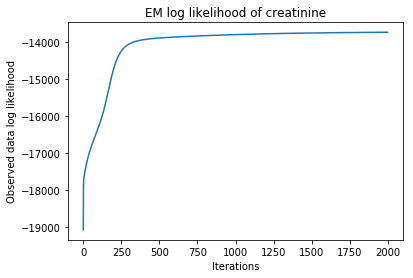

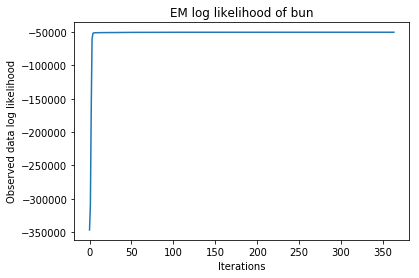

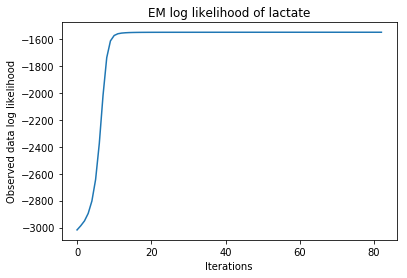

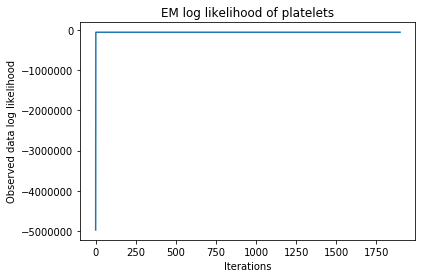

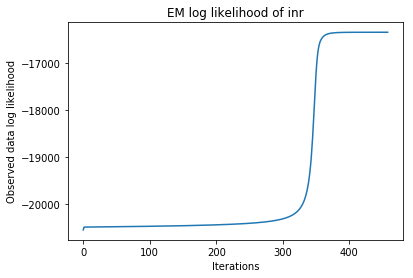

In [16]:
for signal_name in all_signals:
    loglik = all_params[signal_name][7][2]
    plt.plot([i for i in range(len(loglik))], loglik)
    plt.xlabel('Iterations')
    plt.ylabel('Observed data log likelihood')
    plt.title('EM log likelihood of {}'.format(signal_name))
    plt.show()

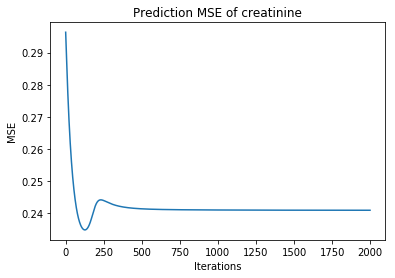

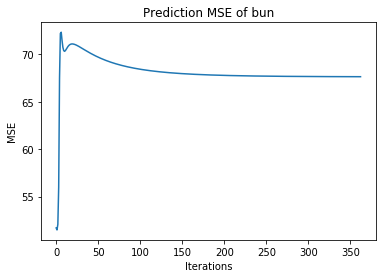

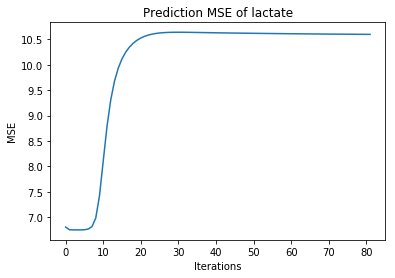

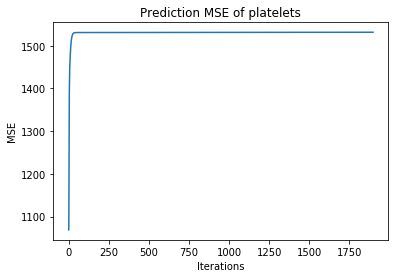

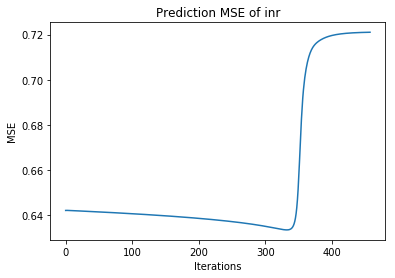

In [21]:
for signal_name in all_signals:
    mse = all_params[signal_name][6][2]
    plt.plot([i for i in range(len(mse))], mse)
    plt.xlabel('Iterations')
    plt.ylabel('MSE')
    plt.title('Prediction MSE of {}'.format(signal_name))
    plt.show()

In [ ]:
for signal_name in all_signals:
    learned_params = all_params[signal_name]
    A = learned_params[0]
    b = learned_params[1]
    initial_state_mean = learned_params[2]
    initial_state_std = learned_params[3]
    transition_std = learned_params[4]
    observation_std = learned_params[5]
    treatment_names, chronic_keywords, demographic_names = signal_context[signal_name]
    print('{} coeffients std'.format(signal_name))
    for i, treatment in enumerate(treatment_names.keys()):
        print('Coefficient for {}: {}'.format(treatment, np.round(np.std(A, axis=0)[:, i], 4)))
    static_types = chronic_keywords + demographic_names
    for j, static in enumerate(static_types):
        print('Coefficient for {}: {}'.format(static, np.round(np.std(b, axis=0)[j], 4)))
    print('initial state mean: {}'.format(np.round(np.std(initial_state_mean), 4)))
    print('initial state std: {}'.format(np.round(np.std(initial_state_std), 4)))
    print('transition noise (std): {}'.format(np.round(np.std(transition_std), 4)))
    print('observation noise (std): {}'.format(np.round(np.std(observation_std), 4)))
    print('')

In [ ]:
plt.plot([i for i in range(len(em.mse))], em.mse)
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.title('Prediction MSE of {}'.format(signal_name))
plt.show()

In [ ]:
for i, treatment in enumerate(treatment_names.keys()):
    print('Coefficient for {}: {}'.format(treatment, np.round(em.A[:, i], 4)))
static_types = chronic_keywords + demographic_names
for j, static in enumerate(static_types):
    print('Coefficient for {}: {}'.format(static, np.round(em.b[j], 4)))
print('initial state mean: {}'.format(round(em.init_z, 4)))
print('initial state std: {}'.format(round(np.sqrt(em.sigma_0), 4)))
print('transition noise (std): {}'.format(round(np.sqrt(em.sigma_1), 4)))
print('observation noise (std): {}'.format(round(np.sqrt(em.sigma_2), 4)))

In [ ]:
patient_index = 0
y_mtx = data['y_mtx'][patient_index, :]
X_mtx = data['X_mtx'][patient_index, :, :]
c_mtx = data['c_mtx'][patient_index, :]
X_prev_mtx = data['X_prev_mtx'][patient_index, :, :]
y_mtx = y_mtx[np.newaxis, :]
X_mtx = X_mtx[np.newaxis, :, :]
c_mtx = c_mtx[np.newaxis, :]
X_prev_mtx = X_prev_mtx[np.newaxis, :, :]

In [ ]:
converge = np.array(em.sos)
initial = np.array(a)

In [ ]:
diff = converge - initial

In [ ]:
np.argsort(diff)[-30:]

In [ ]:
random_patients = np.random.randint(0, em.y.shape[0], 20)
for i in random_patients:
    plot(em, i, 12, signal_name, treatment_types=list(treatment_names.keys()))

### Analysis
Changes
* Only select patients with at least 4 training observations (total of 1821)

On real data
* Issues:
    * treatments coefficients are negative while they should be positive
        * changing initialization doesn't seem to help as model converges in bad local min, and most directions still don't change
    * observation noise is bigger than transition noise
    * run time is long, each iteration takes 4s, M step takes 2.5s, loglik takes 1s
* Reasons:
    * The increasing effects of treatments are not pronouced in the data (see Source Data Analysis)
        * it makes sense that nsaid and aspirin shows small number close to zero since their effects are 50-50.
        * transfusion platelet should be more negative than others, also makes sense.
        * the first number for plasma is a very negative number, but should be close to zero
        * anticoagulant are more negative than platelet, but should be more similar
    * bad noise estimation is expected, specifically underestimated initial state variance and overestimated observational noise 
    
On simulation
* Issues
    * b seems to be harder to identify correctly compared to A (sensitive to initialization)
    * estimated sigma 0 and sigma 2 are very different from the true value (not sensitive to initialization)
        * underestimate sigma 0, overestimate sigma 2
* Reasons
   